In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import quimb as qu
import quimb.tensor as qtn
import cotengra as ctg

opt = ctg.ReusableHyperOptimizer(
    reconf_opts={},
    max_repeats=16,
    parallel=True,
)

/home/ampolloreno/repos/cotengra/cotengra/hyper.py:29: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn("Couldn't import `kahypar` - skipping from default "


In [3]:
from scipy.optimize import dual_annealing
from classical_optimization.qaoa_circuits import execute_qaoa_circuit_and_estimate_cost
import numpy as np
from qiskit import Aer, execute
from coldquanta.qiskit_tools.modeling.neutral_atom_noise_model import create_noise_model
import networkx as nx

np.random.seed(666)
reprate = 25 
one_hour = 60 * 60 #seconds
max_gamma = 2 * np.pi
max_beta = np.pi

n = 20
m = int(n/2)
edges = []
while len(edges) < m:
    edge = (np.random.randint(n), np.random.randint(n))
    if edge not in edges and (edge[1], edge[0]) not in edges and edge[0] != edge[1]:
        
        edges.append(edge)
weights = {edge:((np.random.rand(1)-.5)*2)[0] for edge in edges}
positive_edges = [edge for edge in edges if weights[edge]>0]
#weights = {edge:1 for edge in edges}
graph=nx.Graph()
graph.add_weighted_edges_from([(edge[0], edge[1], weights[edge]) for edge in edges])


terms = weights
circ_ex = None
BASELINE_SHOTS = 5

def objective(graph):
    #Hack for backwards compatibility.
    num_rows = len(graph.nodes)
    num_cols = 1

    history = []
    def store_log(func):
        def logged_func(x):
            ret = func(x)
            history.append((x, ret))
            return ret
        return logged_func

    @store_log
    def gamma_beta_objective(gamma_beta):
        p=1
        gammas = [gamma_beta[1]]
        betas = [gamma_beta[0]]
        circ_ex = qtn.circ_qaoa(terms, p, gammas, betas)
        circ_ex = qtn.circuit_gen.circ_qaoa(terms, p, gammas, betas)
        ZZ = qu.pauli('Z') & qu.pauli('Z')
#         ens = [
#             circ_ex.local_expectation(weight * ZZ, edge, optimize=opt)
#             for edge, weight in terms.items()
#         ]
            
#         return sum(ens).real
        samples = list(circ_ex.simulate_counts(shots_per_point))
        values = []
        for sample in samples:
            value = 0
            for k, v in terms.items():
                if sample[k[0]] != sample[k[1]]:
                    value += 1
            values.append(value)
        return np.mean(values)
    return gamma_beta_objective, history

def expectation_objective(graph):
    #Hack for backwards compatibility.
    num_rows = len(graph.nodes)
    num_cols = 1

    history = []
    def store_log(func):
        def logged_func(x):
            ret = func(x)
            history.append((x, ret))
            return ret
        return logged_func

    @store_log
    def gamma_beta_objective(gamma_beta):
        p=1
        gammas = [gamma_beta[1]]
        betas = [gamma_beta[0]]
        circ_ex = qtn.circ_qaoa(terms, p, gammas, betas)
        circ_ex = qtn.circuit_gen.circ_qaoa(terms, p, gammas, betas)
        ZZ = qu.pauli('Z') & qu.pauli('Z')
        ens = [
            circ_ex.local_expectation(weight * ZZ, edge, optimize=opt)
            for edge, weight in terms.items()
        ]
            
        return sum(ens).real
    return gamma_beta_objective, history



/home/ampolloreno/anaconda3/envs/qaoa/lib/python3.8/site-packages/qiskit/validation/fields/custom.py:76: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numpy.integer, numpy.float,
/home/ampolloreno/anaconda3/envs/qaoa/lib/python3.8/site-packages/qiskit/quantum_info/operators/pauli.py:111: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  z = np.zer

<ipython-input-5-22ea21400588>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels([f"{(i-100)/100}" for i in cb.get_ticks()]) #


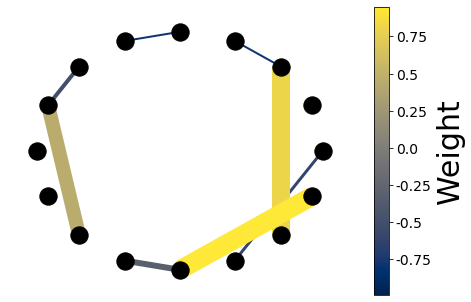

In [5]:
import matplotlib.pyplot as plt
pos=nx.circular_layout(graph)
colors=[int(100+100*weights.get(edge, weights.get((edge[1], edge[0])))) for edge in graph.edges]
widths = [int(10+10*weights.get(edge, weights.get((edge[1], edge[0])))) for edge in graph.edges]
cmap=plt.cm.cividis
vmin = min(colors)
vmax = max(colors)
nx.draw(graph, pos, node_color='k', edge_color=colors, width=widths, edge_cmap=cmap,
           with_labels=False, vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
cb= plt.colorbar(sm)
cb.ax.set_yticklabels([f"{(i-100)/100}" for i in cb.get_ticks()]) #
cb.set_label('Weight', fontsize=30)
#plt.show()
tick_font_size = 14
cb.ax.tick_params(labelsize=tick_font_size)
plt.savefig("/home/ampolloreno/graph.png", dpi=200, bbox_inches='tight')


In [6]:
gammas = [1]
betas = [1]
p=1
# global circ_ex
# if circ_ex is None:
circ_ex = qtn.circuit_gen.circ_qaoa(terms, p, gammas, betas)
# else:
#     new_circ_ex = qtn.circuit_gen.circ_qaoa(terms, p, gammas, betas)
#     tm = new_circ_ex.to_dense_tn()
#     circ_ex.update_params_from(tm)
ZZ = qu.pauli('Z') & qu.pauli('Z')
ens = [
    circ_ex.local_expectation(weight * ZZ, edge, optimize=opt)
    for edge, weight in terms.items()
]

In [7]:
import networkx as nx
obj, hist = expectation_objective(graph)
all_data = []
bound = np.pi
samples = 20
for g in list(reversed(np.linspace(0, bound, num=samples))):
    data = []
    print(g)
    for b in np.linspace(0, bound, num=samples):
        data.append(obj([b, g]))
    all_data.append(data)

3.141592653589793
2.9762456718219092
2.8108986900540254
2.6455517082861415
2.4802047265182576
2.3148577447503738
2.14951076298249
1.984163781214606
1.8188167994467224
1.6534698176788385
1.4881228359109546
1.3227758541430708
1.1574288723751869
0.992081890607303
0.8267349088394192
0.6613879270715354
0.4960409453036515
0.3306939635357677
0.16534698176788384
0.0


(array([-2.5,  0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. ]), [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])


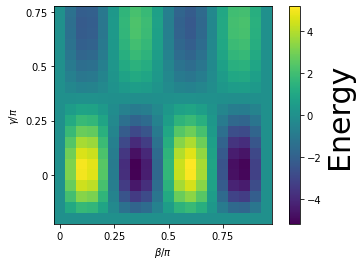

In [8]:
import matplotlib.pyplot as plt
plt.imshow(np.array(all_data))
plt.ylabel(r"$\gamma/\pi$")
plt.xlabel(r"$\beta/\pi$")
print(plt.xticks())
plt.xticks(plt.xticks()[0][1:-1:2], [0, .25, .5, .75])
plt.yticks(plt.yticks()[0][1:-1:2], [0, .25, .5, .75][::-1])
cb = plt.colorbar()
cb.set_label('Energy', fontsize=30)

In [9]:
from es import SimpleGA, CMAES, PEPG, OpenES
NPARAMS = 2
NPOPULATION = 10
oes = OpenES(NPARAMS,                  # number of model parameters
            sigma_init=0.025*np.pi*5,            # initial standard deviation
            sigma_decay=1,         # don't anneal standard deviation
            learning_rate=0.005,         # learning rate for standard deviation
            learning_rate_decay = 0.0, # annealing the learning rate
            popsize=NPOPULATION,       # population size
            antithetic=False,          # whether to use antithetic sampling
            weight_decay=0.00,         # weight decay coefficient
            rank_fitness=False,        # use rank rather than fitness numbers
            forget_best=True)

In [16]:
from tqdm import tqdm
MAX_ITERATION = 50
shots_per_point = BASELINE_SHOTS
fit_func1, history = objective(graph)
fit_func = lambda x: fit_func1(x)
# defines a function to use solver to solve fit_func
def test_solver(solver):
    history = []
    for j in tqdm(range(MAX_ITERATION)):
        solutions = solver.ask()
        fitness_list = np.zeros(solver.popsize)
        for i in range(solver.popsize):
            fitness_list[i] = fit_func(solutions[i])
        solver.tell(fitness_list)
        result = solver.result() # first element is the best solution, second element is the best fitness
        print(result)
        history.append((result))
        if (j+1) % 100 == 0:
            print("fitness at iteration", (j+1), result[1])
    print("local optimum discovered by solver:\n", result[0])
    print("fitness score at this local optimum:", result[1])
    return history, result

In [17]:
history, result = test_solver(oes)


  2%|▏         | 1/50 [00:00<00:27,  1.79it/s]

(array([0.47008133, 0.24899682]), 5.4, 5.4, 0.39269908169872414)


  4%|▍         | 2/50 [00:01<00:27,  1.76it/s]

(array([ 0.28073535, -0.27627915]), 6.0, 6.0, 0.39269908169872414)


  6%|▌         | 3/50 [00:01<00:26,  1.76it/s]

(array([ 0.020799  , -0.43949765]), 6.0, 6.0, 0.39269908169872414)


  8%|▊         | 4/50 [00:02<00:25,  1.77it/s]

(array([-0.85396421, -0.42656629]), 5.8, 5.8, 0.39269908169872414)


 10%|█         | 5/50 [00:02<00:25,  1.78it/s]

(array([-0.48520439, -0.20697181]), 6.8, 6.8, 0.39269908169872414)


 12%|█▏        | 6/50 [00:03<00:24,  1.80it/s]

(array([ 0.29693053, -0.00623461]), 6.6, 6.6, 0.39269908169872414)


 14%|█▍        | 7/50 [00:03<00:23,  1.80it/s]

(array([-0.04120898, -0.626149  ]), 6.2, 6.2, 0.39269908169872414)


 16%|█▌        | 8/50 [00:04<00:23,  1.81it/s]

(array([0.15280896, 0.02229551]), 6.8, 6.8, 0.39269908169872414)


 18%|█▊        | 9/50 [00:05<00:22,  1.81it/s]

(array([0.27136951, 0.45299757]), 6.6, 6.6, 0.39269908169872414)


 20%|██        | 10/50 [00:05<00:22,  1.82it/s]

(array([0.00458546, 0.20450794]), 6.2, 6.2, 0.39269908169872414)


 22%|██▏       | 11/50 [00:06<00:21,  1.82it/s]

(array([ 0.2100114 , -0.10467763]), 6.0, 6.0, 0.39269908169872414)


 24%|██▍       | 12/50 [00:06<00:20,  1.82it/s]

(array([-0.49421013, -0.19233118]), 7.2, 7.2, 0.39269908169872414)


 26%|██▌       | 13/50 [00:07<00:20,  1.80it/s]

(array([-0.46237041, -0.56324819]), 6.8, 6.8, 0.39269908169872414)


 28%|██▊       | 14/50 [00:07<00:20,  1.79it/s]

(array([0.23831736, 0.22987223]), 5.4, 5.4, 0.39269908169872414)


 30%|███       | 15/50 [00:08<00:19,  1.79it/s]

(array([0.44175838, 0.59058286]), 7.2, 7.2, 0.39269908169872414)


 32%|███▏      | 16/50 [00:08<00:18,  1.80it/s]

(array([-0.14703277, -0.21030236]), 5.8, 5.8, 0.39269908169872414)


 34%|███▍      | 17/50 [00:09<00:18,  1.79it/s]

(array([ 0.01022003, -0.30804894]), 6.2, 6.2, 0.39269908169872414)


 36%|███▌      | 18/50 [00:10<00:17,  1.78it/s]

(array([0.04181782, 0.58105988]), 6.2, 6.2, 0.39269908169872414)


 38%|███▊      | 19/50 [00:10<00:17,  1.78it/s]

(array([-0.91418  ,  0.1795394]), 5.6, 5.6, 0.39269908169872414)


 40%|████      | 20/50 [00:11<00:16,  1.79it/s]

(array([-0.48857498, -0.48587714]), 7.0, 7.0, 0.39269908169872414)


 42%|████▏     | 21/50 [00:11<00:16,  1.75it/s]

(array([0.48033804, 0.60817979]), 6.6, 6.6, 0.39269908169872414)


 44%|████▍     | 22/50 [00:12<00:15,  1.76it/s]

(array([0.50301937, 0.57704065]), 5.8, 5.8, 0.39269908169872414)


 46%|████▌     | 23/50 [00:12<00:16,  1.68it/s]

(array([-0.3699815 , -0.10658092]), 5.8, 5.8, 0.39269908169872414)


 48%|████▊     | 24/50 [00:13<00:15,  1.67it/s]

(array([0.06426371, 0.61227929]), 6.4, 6.4, 0.39269908169872414)


 50%|█████     | 25/50 [00:14<00:14,  1.69it/s]

(array([-0.16373164, -0.46887434]), 6.4, 6.4, 0.39269908169872414)


 52%|█████▏    | 26/50 [00:14<00:13,  1.72it/s]

(array([0.00745222, 0.00093367]), 6.2, 6.2, 0.39269908169872414)


 54%|█████▍    | 27/50 [00:15<00:13,  1.75it/s]

(array([-0.32503361, -0.89193587]), 6.0, 6.0, 0.39269908169872414)


 56%|█████▌    | 28/50 [00:15<00:12,  1.77it/s]

(array([-0.55107859, -0.68839973]), 6.4, 6.4, 0.39269908169872414)


 58%|█████▊    | 29/50 [00:16<00:11,  1.76it/s]

(array([ 0.04568981, -0.16699197]), 6.0, 6.0, 0.39269908169872414)


 60%|██████    | 30/50 [00:16<00:11,  1.78it/s]

(array([-0.36533031, -0.85014305]), 6.4, 6.4, 0.39269908169872414)


 62%|██████▏   | 31/50 [00:17<00:10,  1.76it/s]

(array([ 0.15948216, -0.17037626]), 5.6, 5.6, 0.39269908169872414)


 64%|██████▍   | 32/50 [00:18<00:10,  1.76it/s]

(array([0.10059252, 0.09597876]), 6.2, 6.2, 0.39269908169872414)


 66%|██████▌   | 33/50 [00:18<00:09,  1.74it/s]

(array([-0.34037909, -0.82646507]), 6.0, 6.0, 0.39269908169872414)


 68%|██████▊   | 34/50 [00:19<00:09,  1.75it/s]

(array([-0.27715558, -0.7464644 ]), 6.8, 6.8, 0.39269908169872414)


 70%|███████   | 35/50 [00:19<00:08,  1.76it/s]

(array([-0.38947257, -0.6120623 ]), 6.6, 6.6, 0.39269908169872414)


 72%|███████▏  | 36/50 [00:20<00:07,  1.76it/s]

(array([0.01416588, 0.10806706]), 6.2, 6.2, 0.39269908169872414)


 74%|███████▍  | 37/50 [00:20<00:07,  1.76it/s]

(array([-0.36071529, -0.33972812]), 6.2, 6.2, 0.39269908169872414)


 76%|███████▌  | 38/50 [00:21<00:06,  1.78it/s]

(array([-0.26499761, -0.21876502]), 6.0, 6.0, 0.39269908169872414)


 78%|███████▊  | 39/50 [00:22<00:06,  1.78it/s]

(array([0.43441545, 0.1018076 ]), 6.6, 6.6, 0.39269908169872414)


 80%|████████  | 40/50 [00:22<00:05,  1.78it/s]

(array([-0.52982185, -0.36385482]), 7.2, 7.2, 0.39269908169872414)


 82%|████████▏ | 41/50 [00:23<00:05,  1.76it/s]

(array([0.63821815, 0.43984466]), 7.6, 7.6, 0.39269908169872414)


 84%|████████▍ | 42/50 [00:23<00:04,  1.75it/s]

(array([-0.05014169, -0.19132975]), 5.6, 5.6, 0.39269908169872414)


 86%|████████▌ | 43/50 [00:24<00:03,  1.76it/s]

(array([0.45516495, 0.39143847]), 6.4, 6.4, 0.39269908169872414)


 88%|████████▊ | 44/50 [00:24<00:03,  1.75it/s]

(array([0.58189894, 0.62665415]), 6.2, 6.2, 0.39269908169872414)


 90%|█████████ | 45/50 [00:25<00:02,  1.75it/s]

(array([-0.30755491, -0.44090818]), 7.0, 7.0, 0.39269908169872414)


 92%|█████████▏| 46/50 [00:26<00:02,  1.76it/s]

(array([0.24918676, 0.61866486]), 6.6, 6.6, 0.39269908169872414)


 94%|█████████▍| 47/50 [00:26<00:01,  1.76it/s]

(array([-0.25485519, -0.32608531]), 7.2, 7.2, 0.39269908169872414)


 96%|█████████▌| 48/50 [00:27<00:01,  1.77it/s]

(array([-0.37411436,  0.12606636]), 6.2, 6.2, 0.39269908169872414)


 98%|█████████▊| 49/50 [00:27<00:00,  1.77it/s]

(array([ 0.32648077, -0.01764607]), 5.8, 5.8, 0.39269908169872414)


100%|██████████| 50/50 [00:28<00:00,  1.77it/s]

(array([-0.27489909, -0.60216183]), 6.2, 6.2, 0.39269908169872414)
local optimum discovered by solver:
 [-0.27489909 -0.60216183]
fitness score at this local optimum: 6.2


(array([-2.5,  0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. ]), [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])


([<matplotlib.axis.YTick at 0x7ff323cd91c0>,
 [Text(0, 0.0, '0.75'),
  Text(0, 5.0, '0.5'),
  Text(0, 10.0, '0.25'),
  Text(0, 15.0, '0')])

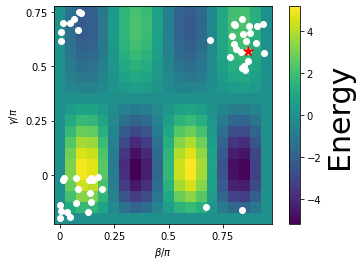

In [18]:
plt.imshow(all_data)
cb = plt.colorbar()
cb.set_label('Energy', fontsize=30)
xys = [h[0] for h in history]
x = [el[0]%(bound)*(samples-1)/(bound) for el in xys]
y = [(bound - (el[1])%(bound))*(samples-1)/(bound) for el in xys]
plt.scatter(x, y, c='w')
plt.scatter([result[0][0]%(bound)*(samples-1)/(bound)], [(bound - (result[0][1]%(bound)))*(samples-1)/(bound)], c='red', marker='*', s=100)
plt.ylabel(r"$\gamma/\pi$")
plt.xlabel(r"$\beta/\pi$")
print(plt.xticks())
plt.xticks(plt.xticks()[0][1:-1:2], [0, .25, .5, .75])
plt.yticks(plt.yticks()[0][1:-1:2], [0, .25, .5, .75][::-1])

# Annealing

In [13]:
shots_per_point = NPOPULATION*BASELINE_SHOTS
from tqdm import tqdm
annealing_attempts = []
func, history2 = objective(graph)
seed = 1
np.random.seed(seed)
initial_gamma_beta = [np.random.rand() * max_param for max_param in (max_gamma, max_beta)]
result2 = dual_annealing(
    lambda x: -1*func(x),
    bounds=[(0, max_gamma),
            (0, max_beta)],
    x0=np.array(initial_gamma_beta),
    # One annealing attempt.
    maxiter=10,
    maxfun=one_hour*reprate,
    seed=1)
result2.fun = -result2.fun
(result2.x, result2.fun)        

(array([0.33005245, 1.09205207]), 6.2)

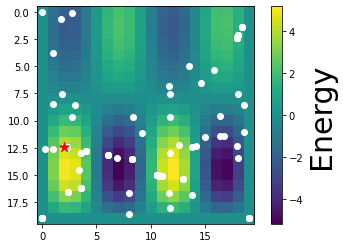

In [14]:
xys2 = [h[0] for h in history2]
x2 = [el[0]%(bound)*(samples-1)/(bound) for el in xys2]
y2 = [(bound - (el[1])%(bound))*(samples-1)/(bound) for el in xys2]
plt.scatter(x2,y2, c='w')
plt.scatter([result2.x[0]%(bound)*(samples-1)/(bound)], [(bound - (result2.x[1]%(bound)))*(samples-1)/(bound)], c='red', marker='*', s=100)
plt.imshow(all_data)
cb = plt.colorbar()
cb.set_label('Energy', fontsize=30)

In [15]:
len(x2)/10

28.7